In [1]:
import pickle
import gzip
import numpy as np
import scipy
import pandas as pd
import tensorflow as tf
import keras
import keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.applications import imagenet_utils, mobilenet_v2
from keras import backend as K
from time import time
from keras import losses
from sklearn.metrics import  roc_curve, roc_auc_score, classification_report, confusion_matrix
import glob
from PIL import Image
import h5py
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import sklearn.gaussian_process as gp
from sklearn.metrics import f1_score

%matplotlib inline

Using TensorFlow backend.


Para leer las features que vienen desde InceptionV3. 2048 features por imagen.

In [2]:
#Train de Kaggle: (56827 imágenes)

with h5py.File("/home/stoledoc/work/datanfs/stoledoc/jama16-retina-replication-master/inceptionv3_features_kaggle_train.hdf5", "r") as datafile:
    features_kaggle_train = datafile["features"][:]
    retinopathy_kaggle_train = datafile["Retinopathy"][:]

#Test de Kaggle: (8790 imágenes)

with h5py.File("/home/stoledoc/work/datanfs/stoledoc/jama16-retina-replication-master/inceptionv3_features_kaggle_test.hdf5", "r") as datafile:
    features_kaggle_test = datafile["features"][:]
    retinopathy_kaggle_test = datafile["Retinopathy"][:]

#Messidor2: (1748 imágenes)

with h5py.File("/home/stoledoc/work/datanfs/stoledoc/jama16-retina-replication-master/inceptionv3_features_messidor2.hdf5", "r") as datafile:
    features_messidor2 = datafile["features"][:]
    retinopathy_messidor2 = datafile["Retinopathy"][:]

In [3]:
import pandas as pd

In [4]:
df_train = pd.read_csv('kaggle_train_levels.csv', header = None)
df_test = pd.read_csv('kaggle_test_levels.csv', header = None)

In [5]:
levels_kaggle_train = np.asarray(df_train[1])
levels_kaggle_test = np.asarray(df_test[1])

Contando cuantas de cada nivel 

In [6]:
for i in range(5):
    print('train level ',i, ':', np.count_nonzero(levels_kaggle_train == i))
for i in range(5):
    print(' test level ',i, ':', np.count_nonzero(levels_kaggle_test == i))

train level  0 : 37209
train level  1 : 3479
train level  2 : 12873
train level  3 : 2046
train level  4 : 1220
 test level  0 : 7407
 test level  1 : 689
 test level  2 : 0
 test level  3 : 0
 test level  4 : 694


Vamos a armar un conjunto de train balanceado para el Gaussian Process:

3660 Referibles:

1220 de 4;

1220 de 3;

1220 de 2;

3660 No Referibles:

1830 de 1;

1830 de 0;

In [7]:
features_kaggle_train_0 = features_kaggle_train[np.where(levels_kaggle_train == 0)]
features_kaggle_train_1 = features_kaggle_train[np.where(levels_kaggle_train == 1)]
features_kaggle_train_2 = features_kaggle_train[np.where(levels_kaggle_train == 2)]
features_kaggle_train_3 = features_kaggle_train[np.where(levels_kaggle_train == 3)]
features_kaggle_train_4 = features_kaggle_train[np.where(levels_kaggle_train == 4)]

In [8]:
features_kaggle_train_0_selected = features_kaggle_train_0[np.random.choice(features_kaggle_train_0.shape[0], size = 1830, replace = False),:]
features_kaggle_train_1_selected = features_kaggle_train_1[np.random.choice(features_kaggle_train_1.shape[0], size = 1830, replace = False),:]
features_kaggle_train_2_selected = features_kaggle_train_2[np.random.choice(features_kaggle_train_2.shape[0], size = 1220, replace = False),:]
features_kaggle_train_3_selected = features_kaggle_train_3[np.random.choice(features_kaggle_train_3.shape[0], size = 1220, replace = False),:]
features_kaggle_train_4_selected = features_kaggle_train_4

X_train = np.concatenate([features_kaggle_train_0_selected, features_kaggle_train_1_selected, features_kaggle_train_2_selected, features_kaggle_train_3_selected, features_kaggle_train_4_selected], axis = 0)

In [9]:
levels_kaggle_train_0 = np.zeros(1830)
levels_kaggle_train_1 = np.ones(1830)
levels_kaggle_train_2 = np.ones(1220)*2
levels_kaggle_train_3 = np.ones(1220)*3
levels_kaggle_train_4 = np.ones(1220)*4

y_train_levels = np.concatenate([levels_kaggle_train_0, levels_kaggle_train_1, levels_kaggle_train_2, levels_kaggle_train_3, levels_kaggle_train_4], axis = 0)

In [10]:
print(X_train.shape)
print(y_train_levels.shape)

(7320, 2048)
(7320,)


Ahora sí el Gaussian Process

In [14]:
kernel = 0.712**2 * RBF(length_scale=8.11, length_scale_bounds=(8.105, 8.115)) \
    + WhiteKernel(noise_level=0.358, noise_level_bounds=(0.3575, 0.3585))

In [17]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, normalize_y = True, n_restarts_optimizer = 1)

In [18]:
gpr.fit(X_train, y_train_levels)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=0.712**2 * RBF(length_scale=8.11) + WhiteKernel(noise_level=0.358),
                         n_restarts_optimizer=1, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=0)

In [19]:
from joblib import dump, load
dump(gpr, 'gpr_kaggle_train_voets_inceptionv3_features_balanced_paper.joblib')

['gpr_kaggle_train_voets_inceptionv3_features_2_balanced_paper.joblib']

In [20]:
params = gpr.kernel_.get_params()

In [365]:
params

{'k1': 0.715**2 * RBF(length_scale=8.11),
 'k2': WhiteKernel(noise_level=0.357),
 'k1__k1': 0.715**2,
 'k1__k2': RBF(length_scale=8.11),
 'k1__k1__constant_value': 0.5106442564683533,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 8.114999999999998,
 'k1__k2__length_scale_bounds': (8.105, 8.115),
 'k2__noise_level': 0.3575,
 'k2__noise_level_bounds': (0.3575, 0.3585)}

In [610]:
y_pred, std = gpr.predict(features_kaggle_test, return_std=True)

In [611]:
MSE = ((y_pred-levels_kaggle_test)**2).mean()

In [612]:
MSE

0.9388953686181299

In [613]:
base = np.array(range(8790))

In [614]:
print(np.mean(y_pred[0:7407]))
print(np.mean(y_pred[7407:8096]))
print(np.mean(y_pred[8096:8790]))

0.8073210427480555
0.8138464760295127
3.087987186345832


In [615]:
y_mean = np.zeros(8790)
for i in range(0,7407):
    y_mean[i] = np.mean(y_pred[0:7407])
for i in range(7407,8096):
    y_mean[i] = np.mean(y_pred[7407:8096])
for i in range(8096,8790):
    y_mean[i] = np.mean(y_pred[8096:8790])

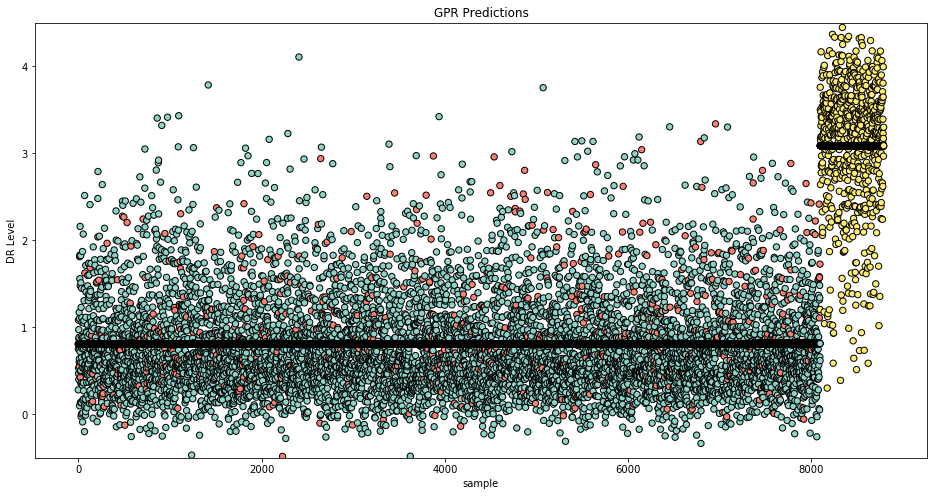

In [57]:
fig = plt.figure(1, figsize=(16, 8))

plt.scatter(base, y_pred, c = levels_kaggle_test,  cmap=plt.cm.Set3, edgecolor='k', s=40)
plt.scatter(base, y_mean, c = levels_kaggle_test,  cmap=plt.cm.Set3, edgecolor='k', s=40)
plt.title("GPR Predictions")
plt.xlabel("sample")
plt.ylim(-0.5,4.5)
#axes.set_ylim([-0.5,4.5])
plt.ylabel("DR Level")

plt.show()

In [622]:
binary_true = retinopathy_kaggle_test

binary_pred = np.zeros(8790)

for i in range(8790):
    if y_pred[i] >= 1.5:
        binary_pred[i] = 1.
        
f1_score(binary_true, binary_pred)

0.5628485628485629

In [617]:
x = np.linspace(2.660, 2.661, num = 200)

In [618]:
f1 = []
for j in x:
    binary_pred = np.zeros(8790)
    for i in range(8790):
        if y_pred[i] >= j:
            binary_pred[i] = 1.
    f1.append(f1_score(binary_true, binary_pred))

In [619]:
f1 = np.array(f1)

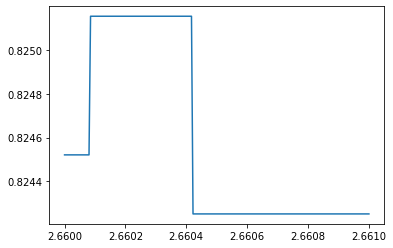

In [109]:
plt.plot(x, f1)

In [623]:
confusion_matrix(binary_true, binary_pred)

array([[7115,  981],
       [  38,  656]])

In [624]:
confusion_matrix(binary_true, binary_pred)

array([[7115,  981],
       [  38,  656]])

In [625]:
f1_score(binary_true, binary_pred)

0.5628485628485629

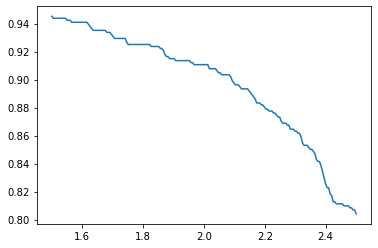

In [281]:
x = np.linspace(1.5, 2.5, num = 200)
tpr = []
for j in x:
    binary_pred = np.zeros(8790)
    for i in range(8790):
        if y_pred[i] >= j:
            binary_pred[i] = 1.
    tp = (np.count_nonzero(binary_pred[np.where(binary_true == 1)])/694)
    tpr.append(tp)
plt.plot(x, tpr)                

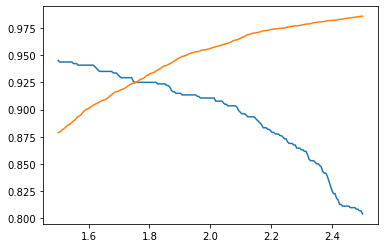

In [282]:
x = np.linspace(1.5, 2.5, num = 200)
tpr = []
fpr = []
for j in x:
    binary_pred = np.zeros(8790)
    for i in range(8790):
        if y_pred[i] >= j:
            binary_pred[i] = 1.
    tp = (np.count_nonzero(binary_pred[np.where(binary_true == 1)])/694)
    tpr.append(tp)
    fp = 1-(np.count_nonzero(binary_pred[np.where(binary_true == 0)]==1)/8096)
    fpr.append(fp)
plt.plot(x, tpr)
plt.plot(x, fpr)  

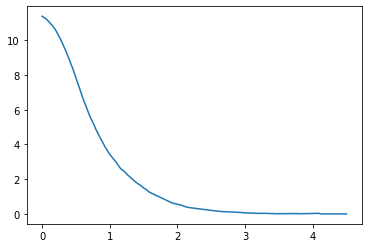

In [219]:
x = np.linspace(0, 4.5, num = 200)
tpr = []
for j in x:
    binary_pred = np.zeros(8790)
    for i in range(8790):
        if y_pred[i] >= j:
            binary_pred[i] = 1.
    tp = (np.count_nonzero(binary_pred[np.where(binary_true == 0)]==1)/np.count_nonzero(binary_pred[np.where(binary_true == 1)]))
    tpr.append(tp)
plt.plot(x, tpr)  

In [230]:
y_pred_0 = binary_pred[np.where(binary_true == 0)]

In [231]:
y_pred_0.shape

(8096,)

In [232]:
f1_score(np.zeros(8096), y_pred_0,average="macro")

0.4784513302840946

In [233]:
y_pred_1 = binary_pred[np.where(binary_true == 1)]

In [234]:
np.count_nonzero(y_pred_1)

647

In [235]:
f1_score(np.ones(694), y_pred_1,average="macro")

0.482475764354959

In [236]:
target_names = ['non-referable', 'referable']
print(classification_report(binary_true, binary_pred, target_names=target_names))

               precision    recall  f1-score   support

non-referable       0.99      0.92      0.95      8096
    referable       0.49      0.93      0.64       694

     accuracy                           0.92      8790
    macro avg       0.74      0.92      0.80      8790
 weighted avg       0.95      0.92      0.93      8790



In [626]:
dif = binary_true - binary_pred

In [627]:
std_TP = std[np.where((dif == 0) & (binary_true == 1))]
std_TN = std[np.where((dif == 0) & (binary_true == 0))]
std_TN_TP = std[np.where((dif == 0))]
std_FN = std[np.where(dif == 1)]
std_FP = std[np.where(dif == -1)]
std_FN_FP = np.concatenate([std_FN, std_FP])
#std_TN_TP = reject_outliers(std_TN_TP,2)

[Text(0, 0, 'FN_FP'),
 Text(0, 0, 'FP'),
 Text(0, 0, 'FN'),
 Text(0, 0, 'TP'),
 Text(0, 0, 'TN'),
 Text(0, 0, 'TN_TP')]

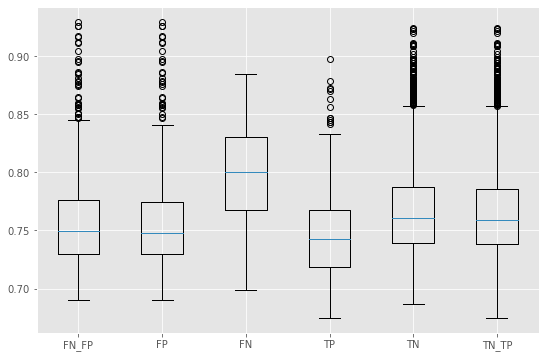

In [628]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot([std_FN_FP, std_FP, std_FN, std_TP, std_TN, std_TN_TP])
ax.set_xticklabels(['FN_FP','FP', 'FN', 'TP', 'TN', 'TN_TP'])

In [629]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [630]:
std_TP = reject_outliers(std_TP, m=2)
std_TN = reject_outliers(std_TN, m=2)
std_FN = reject_outliers(std_FN, m=2)
std_FP = reject_outliers(std_FP, m=2)

In [631]:
from matplotlib.ticker import FormatStrFormatter



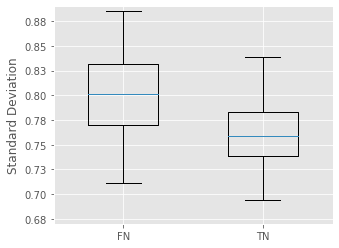

In [641]:
fig = plt.figure(1, figsize=(5, 4))

# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot([std_FN, std_TN],widths=(0.5,0.5))
ax.set_ylim(0.67, 0.89)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xticklabels([ 'FN', 'TN'])
ax.set_ylabel('Standard Deviation')
plt.savefig('FN_TN.eps')

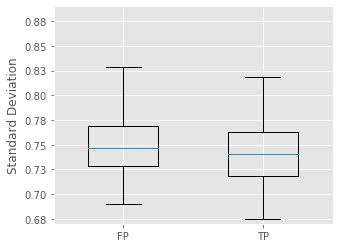

In [642]:
fig = plt.figure(1, figsize=(5, 4))

# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot([std_FP, std_TP], widths=(0.5,0.5))
ax.set_ylim(0.67, 0.89)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xticklabels(['FP', 'TP'])
ax.set_ylabel('Standard Deviation')
plt.savefig('FP_TP.eps')

In [530]:
y_prob = y_pred - y_pred.min()
y_prob = y_prob/y_prob.max()

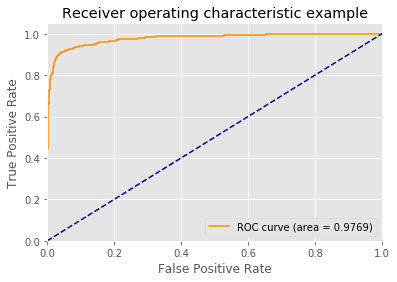

In [408]:
fpr, tpr, _ = roc_curve(binary_true, y_prob)
#fpr, tpr, _ = roc_curve(y_vali, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()

plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Ahora para messidor

In [531]:
y_pred, std = gpr.predict(features_messidor2, return_std=True)

0.7833231279100389
2.2003080272825515


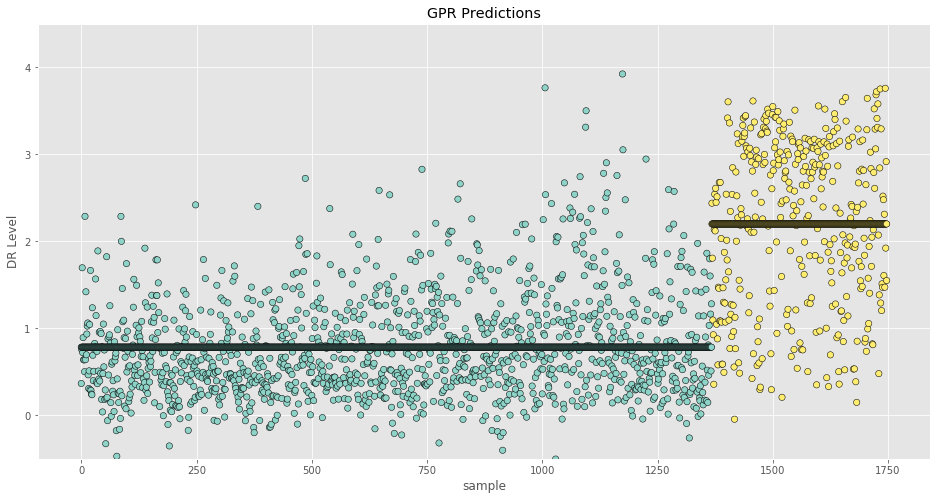

In [410]:
base = np.array(range(1748))
print(np.mean(y_pred[0:1368]))
print(np.mean(y_pred[1368:1748]))

y_mean = np.zeros(1748)
for i in range(0,1368):
    y_mean[i] = np.mean(y_pred[0:1368])
for i in range(1368,1748):
    y_mean[i] = np.mean(y_pred[1368:1748])
    
fig = plt.figure(1, figsize=(16, 8))

plt.scatter(base, y_pred, c = retinopathy_messidor2,  cmap=plt.cm.Set3, edgecolor='k', s=40)
plt.scatter(base, y_mean, c = retinopathy_messidor2,  cmap=plt.cm.Set3, edgecolor='k', s=40)
plt.title("GPR Predictions")
plt.xlabel("sample")
plt.ylim(-0.5,4.5)
#axes.set_ylim([-0.5,4.5])
plt.ylabel("DR Level")

plt.show()

In [532]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [533]:
binary_true = retinopathy_messidor2

In [476]:
binary_pred = np.ones(1748)*2

Beta = np.linspace(1.3, 1.8, 51)
Alpha = np.linspace(0.69, 0.83, 15)
f1 = 0

for beta in Beta:
    for alpha in Alpha:
        for i in range(1748) :
            if y_pred[i] > beta and std[i]<alpha:
                binary_pred[i] = 1.
            if y_pred[i] > beta and std[i]>alpha:
                binary_pred[i] = 0.
            if y_pred[i] < beta :
                binary_pred[i] = 0
        if f1_score(binary_true, binary_pred) > f1:
            f1 = f1_score(binary_true, binary_pred)
            alpha_opt = alpha
            beta_opt = beta
            conf_matrix = confusion_matrix(binary_true, binary_pred)
            specificity = conf_matrix[1,1]/380
            sensitivity = conf_matrix[0,0]/1368

print('Alpha = ', alpha_opt, ', Beta = ', beta_opt, ', f1 = ', f1, ', Specificity = ', specificity, ', Sensitivity = ', sensitivity)

Alpha =  0.82 , Beta =  1.75 , f1 =  0.6947082767978291 , Specificity =  0.6736842105263158 , Sensitivity =  0.9261695906432749


In [495]:
binary_pred = np.ones(1748)*2

Beta = np.linspace(1.3, 1.8, 100)
Alpha = np.linspace(0.69, 0.83, 28)
spec = 0.70
sens = 0.80
for beta in Beta:
    for alpha in Alpha:
        for i in range(1748) :
            if y_pred[i] > beta and std[i]<alpha:
                binary_pred[i] = 1.
            if y_pred[i] > beta and std[i]>alpha:
                binary_pred[i] = 0.
            if y_pred[i] < beta :
                binary_pred[i] = 0
        conf_matrix = confusion_matrix(binary_true, binary_pred)
        specificity = conf_matrix[1,1]/380
        sensitivity = conf_matrix[0,0]/1368
        
        if specificity>spec and sensitivity>sens:
            spec = specificity
            sens = sensitivity
            alpha_opt = alpha
            beta_opt = beta

print('Alpha = ', alpha_opt, ', Beta = ', beta_opt, ', Specificity = ', spec, ', Sensitivity = ', sens)

Alpha =  0.8144444444444444 , Beta =  1.4464646464646465 , Specificity =  0.7394736842105263 , Sensitivity =  0.8676900584795322


In [509]:
binary_pred = np.ones(1748)

Beta = np.linspace(1.3, 1.8, 100)
Alpha = np.linspace(0.69, 0.83, 28)
spec = 0.70
sens = 0.80
for beta in Beta:
    for alpha in Alpha:
        for i in range(1748) :
            if y_pred[i] < beta and std[i]<alpha:
                binary_pred[i] = 0.
            
        conf_matrix = confusion_matrix(binary_true, binary_pred)
        specificity = conf_matrix[1,1]/380
        sensitivity = conf_matrix[0,0]/1368
        
        if specificity>spec and sensitivity>sens:
            spec = specificity
            sens = sensitivity
            alpha_opt = alpha
            beta_opt = beta

print('Alpha = ', alpha_opt, ', Beta = ', beta_opt, ', Specificity = ', spec, ', Sensitivity = ', sens)

Alpha =  0.83 , Beta =  1.3 , Specificity =  0.7710526315789473 , Sensitivity =  0.8011695906432749


In [534]:
binary_pred = np.ones(1748)*2

for i in range(1748) :
    if y_pred[i] > 1.5 and std[i]<0.82:
        binary_pred[i] = 1.
    if y_pred[i] > 1.5 and std[i]>0.82:
        binary_pred[i] = 0.
    if y_pred[i] < 1.5 and std[i]<0.84:
        binary_pred[i] = 0.
    if y_pred[i] < 1.5 and std[i]>0.84:
        binary_pred[i] = 1.
            
        
conf_matrix = confusion_matrix(binary_true, binary_pred)
print(conf_matrix)

[[1183  185]
 [ 105  275]]


In [471]:
print(conf_matrix[0,0])
print(conf_matrix[0,1])
print(conf_matrix[1,0])
print(conf_matrix[1,1])

1270
98
125
255


In [597]:
binary_pred = np.zeros(1748)

for i in range(1748):
    if y_pred[i] >= 1.5 :
        binary_pred[i] = 1.
        
confusion_matrix(binary_true, binary_pred)

array([[1201,  167],
       [ 107,  273]])

In [606]:
for i in range(1748):
    if binary_pred[i] == 0:
        if std[i] > 0.84:
            binary_pred[i] = 1.
confusion_matrix(binary_true, binary_pred)

array([[1182,  186],
       [ 105,  275]])

In [607]:
for i in range(1748):
    if binary_pred[i] == 1:
        if std[i] > 0.82:
            binary_pred[i] = 0.
confusion_matrix(binary_true, binary_pred)

array([[1204,  164],
       [ 107,  273]])

In [413]:
f1_score(binary_true, binary_pred)

0.6658536585365854

In [414]:
target_names = ['non-referable', 'referable']
print(classification_report(binary_true, binary_pred, target_names=target_names))

               precision    recall  f1-score   support

non-referable       0.92      0.88      0.90      1368
    referable       0.62      0.72      0.67       380

     accuracy                           0.84      1748
    macro avg       0.77      0.80      0.78      1748
 weighted avg       0.85      0.84      0.85      1748



In [415]:
dif = binary_true - binary_pred
std_TP = std[np.where((dif == 0) & (binary_true == 1))]
std_TN = std[np.where((dif == 0) & (binary_true == 0))]
std_FN = std[np.where(dif == 1)]
std_FP = std[np.where(dif == -1)]

In [416]:
std_TP = reject_outliers(std_TP, m=2)
std_TN = reject_outliers(std_TN, m=2)
std_FN = reject_outliers(std_FN, m=2)
std_FP = reject_outliers(std_FP, m=2)

[Text(0, 0, 'FP'), Text(0, 0, 'FN'), Text(0, 0, 'TP'), Text(0, 0, 'TN')]

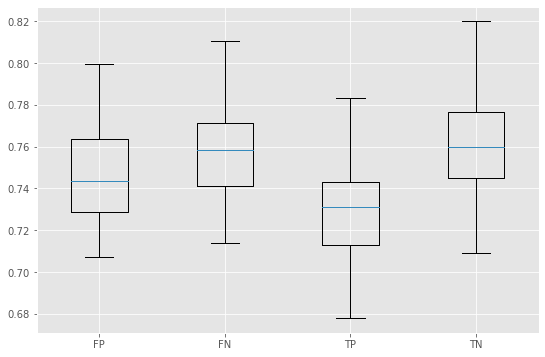

In [417]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot([std_FP, std_FN, std_TP, std_TN])
ax.set_xticklabels(['FP', 'FN', 'TP', 'TN'])

In [418]:
y_prob = y_pred - y_pred.min()
y_prob = y_prob/y_prob.max()

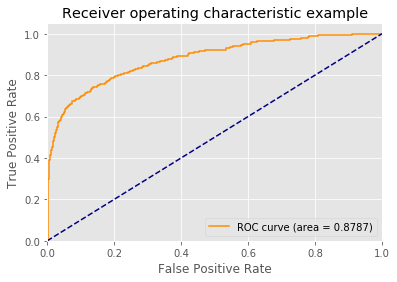

In [419]:
fpr, tpr, _ = roc_curve(retinopathy_messidor2, y_prob)
#fpr, tpr, _ = roc_curve(y_vali, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()

plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

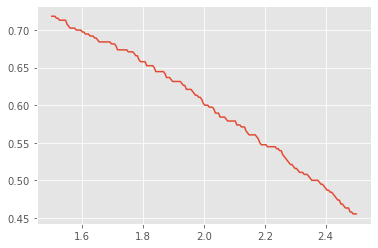

In [420]:
x = np.linspace(1.5, 2.5, num = 200)
tpr = []
for j in x:
    binary_pred = np.zeros(1748)
    for i in range(1748):
        if y_pred[i] >= j:
            binary_pred[i] = 1.
    tp = (np.count_nonzero(binary_pred[np.where(binary_true == 1)])/380)
    tpr.append(tp)
plt.plot(x, tpr)    

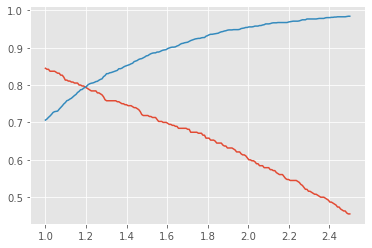

In [421]:
x = np.linspace(1, 2.5, num = 200)
tpr = []
fpr = []
for j in x:
    binary_pred = np.zeros(1748)
    for i in range(1748):
        if y_pred[i] >= j:
            binary_pred[i] = 1.
    tp = (np.count_nonzero(binary_pred[np.where(binary_true == 1)])/380)
    tpr.append(tp)
    fp = 1-(np.count_nonzero(binary_pred[np.where(binary_true == 0)]==1)/1368)
    fpr.append(fp)
plt.plot(x, tpr)
plt.plot(x, fpr)  